### Libraries to be used

In [1]:
import numpy as np
import pandas as pd
import pickle
import gensim
from gensim.models import Word2Vec
from gensim import models
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

### The following classes are designed to be used in the tasks two

In [2]:
class Predictor:
    
    def __init__(self) -> None:
        super().__init__()
        self.instance_data = self.read_instances()
        self.variables_df = self.read_variables()
        self.instances_list = self.transform_instance()
        self.flat_instance_df = self.concatenation()
        self.corpus = self.flat_instance_df['element'].map(lambda row: [row]).tolist()
        
    @staticmethod
    def read_instances() -> list:

        with open("data.pickle", "rb") as file:
            instances = pickle.load(file)
        
        return instances

    @staticmethod
    def read_variables() -> pd.DataFrame:

        with open("variables.pickle", "rb") as file:
            variables = pickle.load(file)

        return pd.DataFrame(variables, columns=('var11', 'var12', 'var13', 'var14', 'var15'))

    def transform_instance(self) -> list:
        instances_list = []
        for instance in range(0, len(self.instance_data[:])):

            elements = []

            for element in range(len(self.instance_data[instance][0])):
                elements.append("ele" + str(element))
            total_df = pd.DataFrame(self.instance_data[instance], columns=elements)
            instances_list.append(total_df)

        return instances_list

    def concatenation(self) -> pd.DataFrame:
        instance = []
        for instances_df in range(0, len(self.instances_list)):
            for column in self.instances_list[instances_df].columns:
                instance.append(pd.concat([self.transform_instance()[instances_df][column], self.variables_df], axis=1)
                                .rename(columns={column: 'element', 'var1': 'var1',
                                                 'var2': 'var2', 'var3': 'var3', 'var4': 'var4', 'var5': 'var5'})
                                )

        instance = pd.concat(instance)
        final_instance = instance[instance["element"].str.contains("nan") == False].reset_index().drop("index", axis=1)
        
        
        return final_instance

In [3]:
to_trantor = Predictor()

# EXERCISE 2

2.1) Perform the necessary transformations of the data so that it consists of six columns. The first column would consist of each element of each group in the data, and the second coulmn would contain its corresponding variables to be predicted. Following the example two cells above, one line in the dataset would be:

In [4]:
to_trantor.flat_instance_df

,element,var11,var12,var13,var14,var15
0,Mercadillo,90.0,30.0,65.0,20.0,5.0
1,Primark,99.0,25.0,65.0,80.0,25.0
2,Donde puedo,97.0,1.0,20.0,20.0,50.0
3,Mercados ambulantes,75.0,65.0,85.0,40.0,90.0
4,No compro,99.0,10.0,96.0,40.0,1.0
...,...,...,...,...,...,...
34781,Snooker,99.0,1.0,35.0,10.0,5.0
34782,Zumba,15.0,20.0,80.0,15.0,30.0
34783,Bouzuki,70.0,15.0,85.0,10.0,20.0
34784,Timple,99.0,20.0,70.0,5.0,70.0


2.2 Transform the elements to a numeric representation using word embeddings. We recommend the gensim library, but feel free to use any other. Transform the dataset again, this time appending the values obtained from the WE to the values to be predicted. This way, the dataset will now have n+5 columns, being n the number of dimension of the WE chosen for the transformation. Note that many items will consist of multiple words, with which many WE are not compatible. To that end, figure out away of "combining" the multiple words of one element (e.g., the mean of the different values, or any other approach you come up with).

#### We are using the simplest model of word embedding 

In [5]:
def tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

data_for_training = list(tagged_document(to_trantor.corpus))
model = gensim.models.doc2vec.Doc2Vec(vector_size=40, min_count=2, epochs=30)
model.build_vocab(data_for_training)
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)

### Creation of the numeric representation of the corpus

In [6]:
to_trantor.flat_instance_df["infer_vector"] = to_trantor.flat_instance_df["element"].\
                                                apply(lambda x: model.infer_vector([x]))

In [7]:
to_trantor.flat_instance_df.drop(["element"], axis=1, inplace=True)
to_trantor.flat_instance_df

,var11,var12,var13,var14,var15,infer_vector
0,90.0,30.0,65.0,20.0,5.0,"[0.008179409, 0.008700813, 0.00847017, -0.0043..."
1,99.0,25.0,65.0,80.0,25.0,"[0.00042638002, 0.0060320054, -0.0084115425, -..."
2,97.0,1.0,20.0,20.0,50.0,"[0.007742472, -0.006338848, 0.0044196956, 0.00..."
3,75.0,65.0,85.0,40.0,90.0,"[0.004653619, -0.007879323, 0.005447209, 0.008..."
4,99.0,10.0,96.0,40.0,1.0,"[-0.0032491789, 0.0061508478, 0.0057833553, 0...."
...,...,...,...,...,...,...
34781,99.0,1.0,35.0,10.0,5.0,"[-0.0075379154, -0.0043836045, 0.011766913, 0...."
34782,15.0,20.0,80.0,15.0,30.0,"[-0.0083402125, -0.006200726, -0.008781448, 0...."
34783,70.0,15.0,85.0,10.0,20.0,"[-0.007012859, -0.010679213, -0.01057968, 0.00..."
34784,99.0,20.0,70.0,5.0,70.0,"[0.011038308, 0.009843322, 0.00797001, -0.0017..."


2.3.1: Choose a set of "pivot" values. These are vectors of the same dimension as the one of the chosen WE. The values of the pivots are arbitrary. You can choose random values, zeros, ones, twos, ..., even an item which has been transformed into its vectorized form in the previous step can be used as a pivot. You have to choose 10 pivots.

### Pivots choosen with psudo-random numbers 

In [8]:
pivot_values = pd.Series([np.random.rand(40), np.random.rand(40),np.random.rand(40),\
               np.random.rand(40),np.random.rand(40),np.random.rand(40),\
               np.random.rand(40),np.random.rand(40),np.random.rand(40),np.random.rand(40)])

2.3.2: Next, you will have to compute a distance (e.g., MSE or any other that you may find more suited to this problem) from each vectorized element, to each pivot.

#### Following the instruction given, we are computing the MSE between

In [9]:
def mse_to_pivots(row, pivot_values) -> list:
    
    infer_variables = []
    for pivot_element in range(len(pivot_values)):
        
        infer_variables.append(mean_squared_error(row, pivot_values.iloc[pivot_element]))
        
    
    return infer_variables

In [10]:
to_trantor.flat_instance_df["mse_to_pivot"] = to_trantor.flat_instance_df["infer_vector"].\
                                                apply(lambda x: mse_to_pivots(x, pivot_values))
mse_to_pivot = to_trantor.flat_instance_df["mse_to_pivot"].apply(pd.Series)

In [11]:
mse_to_pivot.columns=['var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7', 'var8', 'var9', 'var10']
mse_to_pivot

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10
0,0.277783,0.326376,0.441182,0.372562,0.297275,0.319457,0.340955,0.327311,0.336004,0.446072
1,0.273673,0.323362,0.436117,0.370720,0.293343,0.316849,0.336701,0.325443,0.332952,0.442603
2,0.277841,0.326277,0.439304,0.373097,0.296120,0.319040,0.340437,0.327748,0.334825,0.446987
3,0.275610,0.326637,0.441550,0.374201,0.296937,0.318506,0.340583,0.327907,0.336504,0.447544
4,0.277014,0.326817,0.441356,0.372107,0.296488,0.318141,0.341391,0.326297,0.334258,0.445679
...,...,...,...,...,...,...,...,...,...,...
34781,0.276415,0.324687,0.438208,0.370576,0.294065,0.317880,0.338912,0.325781,0.333389,0.444859
34782,0.278178,0.327061,0.442757,0.373949,0.296318,0.320729,0.341382,0.327953,0.336902,0.447566
34783,0.277245,0.327361,0.440891,0.374464,0.297082,0.320145,0.341492,0.330135,0.335780,0.447298
34784,0.277999,0.325340,0.439702,0.372921,0.295268,0.317466,0.339503,0.325751,0.334709,0.445737


2.3.3: These 10 values now represent each element. Append them to the variables, and now you will have a dataset consisting of 15 columns. The first ten will contain the distances from the vectorized version of the elements to each of the topics, and the last five, the variables to be predicted.

### Creation of the data to be used in the neural network model

In [12]:
to_trantor.flat_instance_df = pd.concat([mse_to_pivot, to_trantor.flat_instance_df], axis=1).\
                                drop(["infer_vector","mse_to_pivot"],axis=1)

In [13]:
to_trantor.flat_instance_df

,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15
0,0.277783,0.326376,0.441182,0.372562,0.297275,0.319457,0.340955,0.327311,0.336004,0.446072,90.0,30.0,65.0,20.0,5.0
1,0.273673,0.323362,0.436117,0.370720,0.293343,0.316849,0.336701,0.325443,0.332952,0.442603,99.0,25.0,65.0,80.0,25.0
2,0.277841,0.326277,0.439304,0.373097,0.296120,0.319040,0.340437,0.327748,0.334825,0.446987,97.0,1.0,20.0,20.0,50.0
3,0.275610,0.326637,0.441550,0.374201,0.296937,0.318506,0.340583,0.327907,0.336504,0.447544,75.0,65.0,85.0,40.0,90.0
4,0.277014,0.326817,0.441356,0.372107,0.296488,0.318141,0.341391,0.326297,0.334258,0.445679,99.0,10.0,96.0,40.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34781,0.276415,0.324687,0.438208,0.370576,0.294065,0.317880,0.338912,0.325781,0.333389,0.444859,99.0,1.0,35.0,10.0,5.0
34782,0.278178,0.327061,0.442757,0.373949,0.296318,0.320729,0.341382,0.327953,0.336902,0.447566,15.0,20.0,80.0,15.0,30.0
34783,0.277245,0.327361,0.440891,0.374464,0.297082,0.320145,0.341492,0.330135,0.335780,0.447298,70.0,15.0,85.0,10.0,20.0
34784,0.277999,0.325340,0.439702,0.372921,0.295268,0.317466,0.339503,0.325751,0.334709,0.445737,99.0,20.0,70.0,5.0,70.0


### Normalize data 

In [14]:
variable = 10
X = to_trantor.flat_instance_df.iloc[:, 0:10]
y = to_trantor.flat_instance_df.iloc[:, 13: 14]

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
scaler_x.fit(X)
scaler_y.fit(y)
xscale=scaler_x.transform(X)
yscale=scaler_y.transform(y)    

In [15]:
X_train, X_test, y_train, y_test = train_test_split(xscale, yscale)

### Model of neural network

In [16]:
model = Sequential()
model.add(Dense(10, input_dim=10, kernel_initializer='normal', activation='relu'))
# model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [18]:
history = model.fit(X_train, y_train, epochs=150, batch_size=40,  verbose=1, validation_split=0.2)

Epoch 1/150
522/522 [==============================] - 2s 2ms/step - loss: 0.0770 - mse: 0.0770 - val_loss: 0.0729 - val_mse: 0.0729
Epoch 2/150
522/522 [==============================] - 1s 2ms/step - loss: 0.0724 - mse: 0.0724 - val_loss: 0.0727 - val_mse: 0.0727
Epoch 3/150
522/522 [==============================] - 1s 2ms/step - loss: 0.0722 - mse: 0.0722 - val_loss: 0.0722 - val_mse: 0.0722
Epoch 4/150
522/522 [==============================] - 1s 2ms/step - loss: 0.0721 - mse: 0.0721 - val_loss: 0.0722 - val_mse: 0.0722
Epoch 5/150
522/522 [==============================] - 1s 2ms/step - loss: 0.0720 - mse: 0.0720 - val_loss: 0.0727 - val_mse: 0.0727
Epoch 6/150
522/522 [==============================] - 1s 2ms/step - loss: 0.0721 - mse: 0.0721 - val_loss: 0.0722 - val_mse: 0.0722
Epoch 7/150
522/522 [==============================] - 1s 2ms/step - loss: 0.0721 - mse: 0.0721 - val_loss: 0.0722 - val_mse: 0.0722
Epoch 8/150
522/522 [==============================] - 1s 2ms/step - 

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


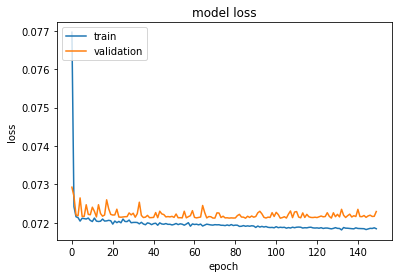

In [19]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [21]:
Xnew = X_test
ynew= model.predict(Xnew)
#invert normalize
ynew = scaler_y.inverse_transform(ynew) 
Xnew = scaler_x.inverse_transform(Xnew)
print("X=%s, Predicted=%s" % (Xnew[0], ynew[0]))

X=[0.27789945 0.32741291 0.44299102 0.37546384 0.29763233 0.31981987
 0.34224106 0.32941739 0.33554306 0.44806013], Predicted=[28.80546]


In [22]:
y_test = scaler_y.inverse_transform(y_test) 

In [23]:
y_test.shape

(8697, 1)

In [24]:
r2_score(y_test, ynew)

-0.0008369898459461567

### Conclusiones
The precision of our learning model is so not good, we could improve it, for example, if we did a broader study about the structure of the data, such as calculating the correlation between the variables and from there doing data engineering to improve our neural network